##Deep Learning Assignment 1##

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
!pip install statsmodels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
from scipy.io import loadmat
raw = loadmat('Xtrain.mat')['Xtrain']  # shape is (N,1) or (1,N)

series = raw.flatten()  # now shape is (N,)
split = int(len(series)*0.8)
train_ser, val_ser = series[:split], series[split:]


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0,1))
train_scaled = scaler.fit_transform(train_ser.reshape(-1,1)).flatten()
val_scaled   = scaler.transform(val_ser.reshape(-1,1)).flatten()


#EDA


Length: 1000
Min: 2.000, Max: 255.000
Mean: 59.894, Std: 46.852


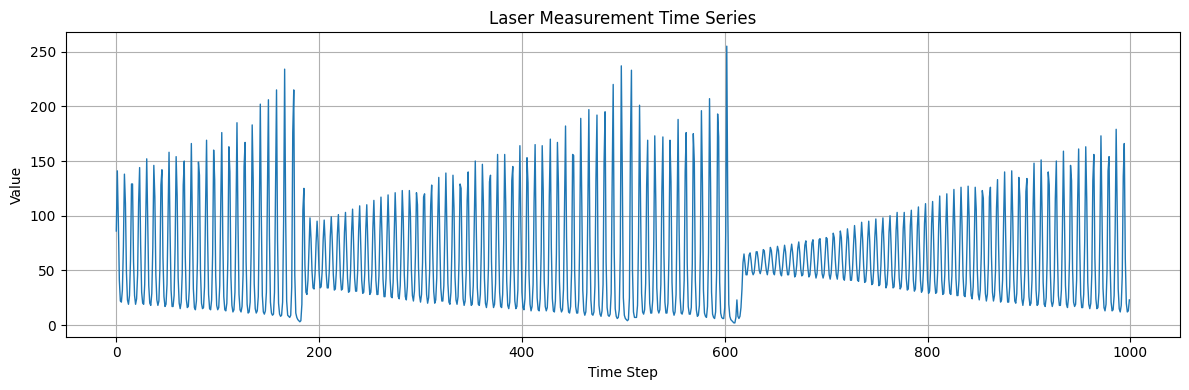

<Figure size 800x400 with 0 Axes>

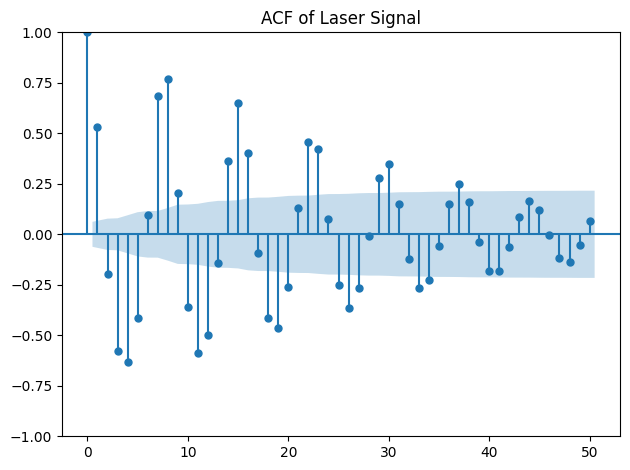

In [9]:

print(f"Length: {len(series)}")
print(f"Min: {series.min():.3f}, Max: {series.max():.3f}")
print(f"Mean: {series.mean():.3f}, Std: {series.std():.3f}")

# 3. Plot full time series
plt.figure(figsize=(12,4))
plt.plot(series, linewidth=1)
plt.title('Laser Measurement Time Series')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Autocorrelation

from statsmodels.graphics.tsaplots import plot_acf


plt.figure(figsize=(8,4))
plot_acf(series, lags=50, title='ACF of Laser Signal')
plt.tight_layout()
plt.show()


#Data Preprocessing

In [10]:
split_idx   = int(0.8 * len(series))
train_series = series[:split_idx]
val_series   = series[split_idx:]


Train scaled min/max: 0.0 1.0
Val   scaled min/max: 0.03952569169960474 0.6996047430830039
X_train shape: (780, 20), y_train shape: (780,)
X_val   shape: (180, 20),   y_val   shape: (180,)


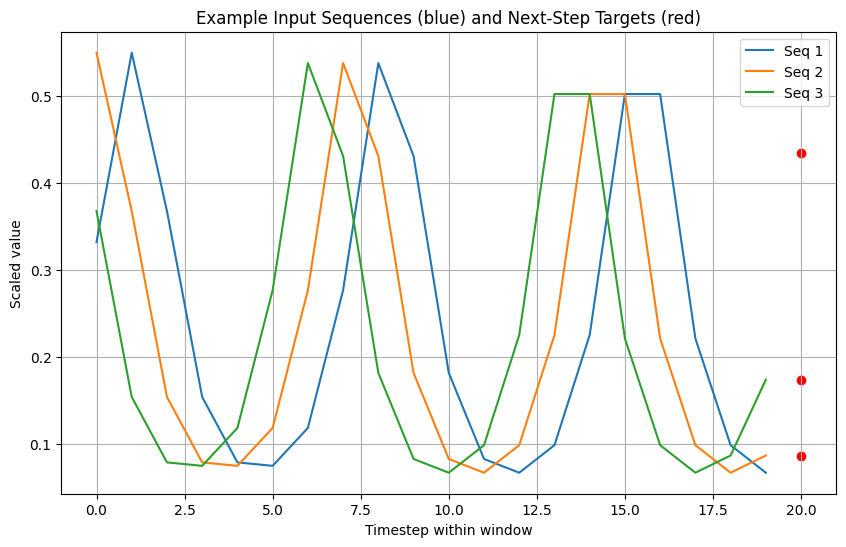

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on train, transform both
train_scaled = scaler.fit_transform(train_series.reshape(-1,1)).flatten()
val_scaled   = scaler.transform(val_series.reshape(-1,1)).flatten()

print("Train scaled min/max:", train_scaled.min(), train_scaled.max())
print("Val   scaled min/max:",   val_scaled.min(),   val_scaled.max())

# --- 3. Sequence builder ---
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 20  # you’ll tune this later

X_train, y_train = create_sequences(train_scaled, window_size)
X_val,   y_val   = create_sequences(val_scaled,   window_size)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val   shape: {X_val.shape},   y_val   shape: {y_val.shape}")

# --- 4. Visualize a few sequences + targets ---
plt.figure(figsize=(10, 6))
for i in range(min(3, len(X_train))):
    plt.plot(range(window_size), X_train[i],          label=f'Seq {i+1}')
    plt.scatter(window_size, y_train[i], color='red')  # target at t = window_size
plt.title('Example Input Sequences (blue) and Next-Step Targets (red)')
plt.xlabel('Timestep within window')
plt.ylabel('Scaled value')
plt.legend()
plt.grid(True)
plt.show()

Model Selection & Motivation:
1. Using an LSTM (Long Short-Term Memory) network for this time series prediction task.
2. Justification: 
   - LSTMs can capture long-range temporal dependencies in the laser measurement data
   - They effectively mitigate vanishing-gradient issues common in sequential data
   - Laser measurements likely contain complex temporal patterns that LSTMs are well-suited to learn
   - LSTMs have proven effective for similar time series forecasting tasks


In [12]:
# 4.1 LSTM Model Architecture
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, seq_len, hidden_size)

        # Get the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        # Apply dropout
        out = self.dropout(lstm_out)
        # Linear layer for prediction
        out = self.fc(out)
        return out

# Create the model
def create_lstm_model(hidden_size=50, dropout_rate=0.2):
    model = LSTMModel(input_size=1, hidden_size=hidden_size, dropout_rate=dropout_rate)
    return model

# Create the model
model = create_lstm_model()
print(model)


# 4.3 Training Setup
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.best_model is not None:
                    model.load_state_dict(self.best_model)
                return True
        return False

early_stopping = EarlyStopping(patience=10)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.reshape(X_train.shape[0], X_train.shape[1], 1))
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val.reshape(X_val.shape[0], X_val.shape[1], 1))
y_val_tensor = torch.FloatTensor(y_val)


LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [13]:
# 3.2 Create sequences (input-output pairs)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Input sequence (X): time steps [i to i+window_size-1]
        X.append(data[i:i+window_size])
        # Target value (y): time step [i+window_size]
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


In [25]:
# 4.4 Training Loop with Different Window Sizes
window_sizes = [5, 10, 20, 30, 50,100]  # Different window sizes to try
num_epochs = 100
batch_size   = 64
results = {}



=== Window size: 5 ===
Epoch 10/100 → train 0.0134, val 0.0052
Epoch 20/100 → train 0.0123, val 0.0042
Epoch 30/100 → train 0.0103, val 0.0038
Epoch 40/100 → train 0.0091, val 0.0024
Epoch 50/100 → train 0.0081, val 0.0024
Epoch 60/100 → train 0.0063, val 0.0016
Epoch 70/100 → train 0.0056, val 0.0013
Epoch 80/100 → train 0.0050, val 0.0010
Epoch 90/100 → train 0.0041, val 0.0006
Epoch 100/100 → train 0.0037, val 0.0006

=== Window size: 10 ===
Epoch 10/100 → train 0.0277, val 0.0218
Epoch 20/100 → train 0.0082, val 0.0040
Epoch 30/100 → train 0.0075, val 0.0016
Epoch 40/100 → train 0.0056, val 0.0009
Epoch 50/100 → train 0.0044, val 0.0007
Epoch 60/100 → train 0.0051, val 0.0013
Early stopping at epoch 66

=== Window size: 20 ===
Epoch 10/100 → train 0.0322, val 0.0267
Epoch 20/100 → train 0.0126, val 0.0057
Epoch 30/100 → train 0.0097, val 0.0038
Epoch 40/100 → train 0.0065, val 0.0020
Epoch 50/100 → train 0.0048, val 0.0008
Epoch 60/100 → train 0.0044, val 0.0007
Epoch 70/100 → tra

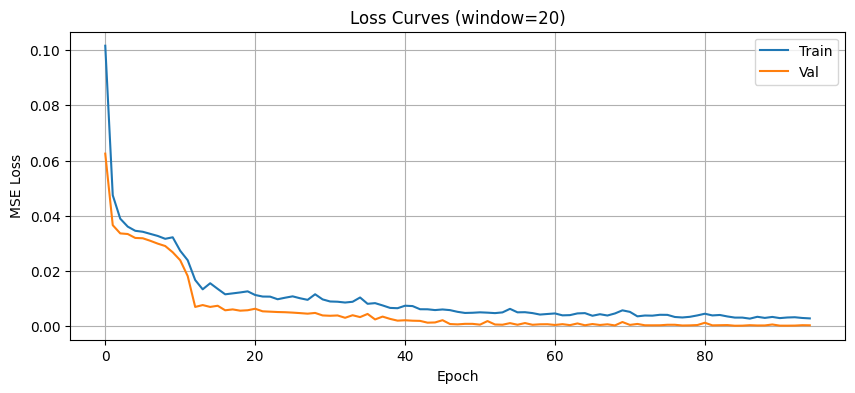

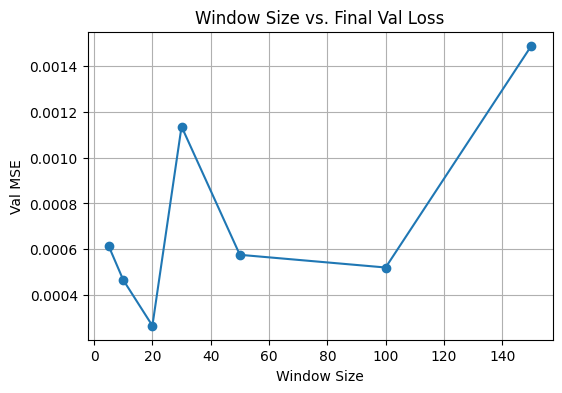

In [35]:
for ws in window_sizes:
    print(f"\n=== Window size: {ws} ===")
    # create sequences
    X_tr, y_tr = create_sequences(train_scaled, ws)
    X_va, y_va = create_sequences(val_scaled,   ws)
    # to tensors
    Xt = torch.tensor(X_tr[...,None], dtype=torch.float32)
    yt = torch.tensor(y_tr[:,None],   dtype=torch.float32)
    Xv = torch.tensor(X_va[...,None], dtype=torch.float32)
    yv = torch.tensor(y_va[:,None],   dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(Xt, yt), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(Xv, yv), batch_size=batch_size)
    # model, optimizer, early stopping
    model = LSTMModel().to(device)
    opt   = optim.Adam(model.parameters(), lr=1e-3)
    es    = EarlyStopping(patience=10)
    train_losses, val_losses = [], []
    # training loop
    for epoch in range(1, num_epochs+1):
        model.train()
        epoch_train = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = nn.MSELoss()(model(Xb), yb)
            loss.backward(); opt.step()
            epoch_train.append(loss.item())
        model.eval()
        epoch_val = []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                epoch_val.append(nn.MSELoss()(model(Xb), yb).item())
        train_losses.append(np.mean(epoch_train))
        val_losses.append(np.mean(epoch_val))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs} → train {train_losses[-1]:.4f}, val {val_losses[-1]:.4f}")
        if es(val_losses[-1], model):
            print(f"Early stopping at epoch {epoch}")
            break

    results[ws] = {
        'model':        model,              # ← save the model itself
        'train_losses': train_losses,
        'val_losses':   val_losses,
        'final_val_loss':    val_losses[-1]
    }


# 8. Select best window size
best_ws = min(results, key=lambda w: results[w]['final_val_loss'])
print(f"\nBest window size = {best_ws}, val loss = {results[best_ws]['final_val_loss']:.4f}")

# 9. Plot losses for best model
plt.figure(figsize=(10,4))
plt.plot(results[best_ws]['train_losses'], label='Train')
plt.plot(results[best_ws]['val_losses'],   label='Val')
plt.title(f"Loss Curves (window={best_ws})")
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.legend(); plt.grid(); plt.show()

# 10. Plot val loss vs window size
plt.figure(figsize=(6,4))
ws_list = list(results.keys())
vlosses = [results[w]['final_val_loss'] for w in ws_list]
plt.plot(ws_list, vlosses, marker='o')
plt.title('Window Size vs. Final Val Loss')
plt.xlabel('Window Size'); plt.ylabel('Val MSE'); plt.grid(); plt.show()

##Using the trained model for 200 window

 Best window size = 20


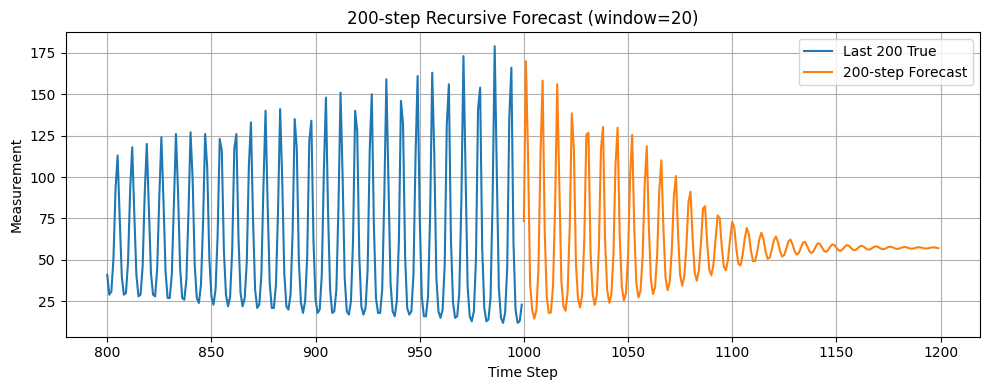

In [37]:
best_ws = min(results.keys(), key=lambda w: results[w]['final_val_loss'])
print(f" Best window size = {best_ws}")

# Retrieve the corresponding trained model
best_model = results[best_ws]['model']
best_model.eval()

# (c) Recursive 200-step forecast
# — Scale the full series
full_scaled = scaler.transform(series.reshape(-1,1)).flatten()

# — Seed with the last best_ws true points
buf = list(full_scaled[-best_ws:])
preds_scaled = []

for _ in range(200):
    x = torch.tensor(buf[-best_ws:], dtype=torch.float32)[None,:,None].to(device)
    with torch.no_grad():
        p = best_model(x).item()
    preds_scaled.append(p)
    buf.append(p)

# — Inverse-scale
preds = scaler.inverse_transform(np.array(preds_scaled)[:,None]).flatten()

#plotting
plt.figure(figsize=(10,4))
#last 200 true points
plt.plot(np.arange(len(series)-200, len(series)), series[-200:], label='Last 200 True')
#Visualize the forecast
plt.plot(np.arange(len(series), len(series)+200), preds, label='200-step Forecast')
plt.xlabel('Time Step')
plt.ylabel('Measurement')
plt.title(f'200-step Recursive Forecast (window={best_ws})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()